In [384]:
# from google.colab import drive
# drive.mount('/content/drive')

In [385]:
!pip install pyspark

In [386]:
from pyspark.sql import DataFrame, SparkSession

spark = SparkSession \
       .builder \
       .config("spark.driver.memory", "15g") \
       .appName("House Price Prediction") \
       .getOrCreate()

spark

In [387]:
from typing import List
import pyspark.sql.types as T
import pyspark.sql.functions as F
from pyspark import SparkFiles
from pyspark.sql.functions import isnull, when, count, col, desc

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


In [388]:
df_train = spark.read.csv("./drive/MyDrive/Colab Notebooks/Hackathon/train.csv", header=True, inferSchema=True)
df_test = spark.read.csv("./drive/MyDrive/Colab Notebooks/Hackathon/test.csv", header=True, inferSchema=True)

In [389]:
print("Train Dataset has ",df_train.count(),"Records/Rows and ",len(df_train.columns),"attributes/columns.")
print("Test Dataset has ",df_test.count(),"Records/Rows and ",len(df_test.columns),"attributes/columns.")

Train Dataset has  1460 Records/Rows and  81 attributes/columns.
Test Dataset has  1459 Records/Rows and  80 attributes/columns.


In [390]:
df_train.toPandas().info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 81 entries, Id to SalePrice
dtypes: int32(35), object(46)
memory usage: 724.4+ KB


Out of 81 columns, 35 columns are numerical and 46 columns are categorical.

In [391]:
df_test.toPandas().info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Columns: 80 entries, Id to SaleCondition
dtypes: int32(26), object(54)
memory usage: 763.8+ KB


Out of 80 columns, 26 columns are numerical and *54* columns are categorical.

In [392]:
print(df_train.dtypes,"\n", df_test.dtypes)


[('Id', 'int'), ('MSSubClass', 'int'), ('MSZoning', 'string'), ('LotFrontage', 'string'), ('LotArea', 'int'), ('Street', 'string'), ('Alley', 'string'), ('LotShape', 'string'), ('LandContour', 'string'), ('Utilities', 'string'), ('LotConfig', 'string'), ('LandSlope', 'string'), ('Neighborhood', 'string'), ('Condition1', 'string'), ('Condition2', 'string'), ('BldgType', 'string'), ('HouseStyle', 'string'), ('OverallQual', 'int'), ('OverallCond', 'int'), ('YearBuilt', 'int'), ('YearRemodAdd', 'int'), ('RoofStyle', 'string'), ('RoofMatl', 'string'), ('Exterior1st', 'string'), ('Exterior2nd', 'string'), ('MasVnrType', 'string'), ('MasVnrArea', 'string'), ('ExterQual', 'string'), ('ExterCond', 'string'), ('Foundation', 'string'), ('BsmtQual', 'string'), ('BsmtCond', 'string'), ('BsmtExposure', 'string'), ('BsmtFinType1', 'string'), ('BsmtFinSF1', 'int'), ('BsmtFinType2', 'string'), ('BsmtFinSF2', 'int'), ('BsmtUnfSF', 'int'), ('TotalBsmtSF', 'int'), ('Heating', 'string'), ('HeatingQC', 'str

The datatypes in both the datasets are not same.
In the test dataset, the columns BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath, BsmtHalfBath, GarageCars, GarageArea are string type which needs to converted to int

In [393]:
cols_type = ["BsmtFinSF1", "BsmtFinSF2", "BsmtUnfSF", "TotalBsmtSF", "BsmtFullBath", "BsmtHalfBath", "GarageCars", "GarageArea"]
for c in cols_type:
  df_test = df_test.withColumn(c, df_test[c].cast('double'))

  # #changing even the columns in train set from int to int
  df_train = df_train.withColumn(c, df_train[c].cast('double'))

In [394]:
df_test.toPandas().info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Columns: 80 entries, Id to SaleCondition
dtypes: float64(8), int32(26), object(46)
memory usage: 763.8+ KB


Removing duplicate rows if any

In [395]:
df_train.dropDuplicates()
df_test.dropDuplicates()

DataFrame[Id: int, MSSubClass: int, MSZoning: string, LotFrontage: string, LotArea: int, Street: string, Alley: string, LotShape: string, LandContour: string, Utilities: string, LotConfig: string, LandSlope: string, Neighborhood: string, Condition1: string, Condition2: string, BldgType: string, HouseStyle: string, OverallQual: int, OverallCond: int, YearBuilt: int, YearRemodAdd: int, RoofStyle: string, RoofMatl: string, Exterior1st: string, Exterior2nd: string, MasVnrType: string, MasVnrArea: string, ExterQual: string, ExterCond: string, Foundation: string, BsmtQual: string, BsmtCond: string, BsmtExposure: string, BsmtFinType1: string, BsmtFinSF1: double, BsmtFinType2: string, BsmtFinSF2: double, BsmtUnfSF: double, TotalBsmtSF: double, Heating: string, HeatingQC: string, CentralAir: string, Electrical: string, 1stFlrSF: int, 2ndFlrSF: int, LowQualFinSF: int, GrLivArea: int, BsmtFullBath: double, BsmtHalfBath: double, FullBath: int, HalfBath: int, BedroomAbvGr: int, KitchenAbvGr: int, K

So no duplicate rows

In [396]:
df_train.show(5)

+---+----------+--------+-----------+-------+------+-----+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+-----------+-----------+---------+------------+---------+--------+-----------+-----------+----------+----------+---------+---------+----------+--------+--------+------------+------------+----------+------------+----------+---------+-----------+-------+---------+----------+----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+-----------+------------+----------+----------+-----------+----------+-----------+------------+----------+----------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+------+-----+-----------+-------+------+------+--------+-------------+---------+
| Id|MSSubClass|MSZoning|LotFrontage|LotArea|Street|Alley|LotShape|LandContour|Utilities|LotConfig|LandSlope|Neighborhood|Condition1|Condition

Removing the Id feature as it is just an index to the rows

In [397]:
# test_id = df_test["Id"]    ##Storing test id because we need it for subission file.
# df_train = df_train.drop("Id")
# df_test = df_test.drop("Id")


*Performing missing value analysis*

Dropping the columns with large number of missing values, and imputing the missing values

In [398]:
df_train.toPandas().describe(include = "object")

,MSZoning,LotFrontage,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,GarageYrBlt,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460,...,1460,1460,1460,1460,1460,1460,1460,1460,1460,1460
unique,5,111,2,3,4,4,2,5,3,25,...,98,4,6,6,3,4,5,5,9,6
top,RL,NA,Pave,NA,Reg,Lvl,AllPub,Inside,Gtl,NAmes,...,NA,Unf,TA,TA,Y,NA,NA,NA,WD,Normal
freq,1151,259,1454,1369,925,1311,1459,1052,1382,225,...,81,605,1311,1326,1340,1453,1179,1406,1267,1198


In [399]:
# import pyspark
# df_null ={}
# for cl in df_train.columns:
#   cntspace =  df_train.where(F.col(cl)=="").count()
#   cntnan = df_train.where(F.col(cl)==np.nan).count()
#   cntna =  df_train.where(F.col(cl)=="NA").count()
#   if cntspace > 0 or cntnan > 0 or cntna > 0:
#      df_null[cl] ={"empty strings" : cntspace, "nan" : cntnan, "na": cntna, "total": cntspace+cntnan+cntna, "Percentage" :(cntspace+cntnan+cntna)/df_data.count() *100}
# df_null =  pd.DataFrame(df_null)
# df_null


In [400]:
df_train.select([count(when(isnull(c), c)).alias(c) for c in df_train.columns]).show()

+---+----------+--------+-----------+-------+------+-----+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+-----------+-----------+---------+------------+---------+--------+-----------+-----------+----------+----------+---------+---------+----------+--------+--------+------------+------------+----------+------------+----------+---------+-----------+-------+---------+----------+----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+-----------+------------+----------+----------+-----------+----------+-----------+------------+----------+----------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+------+-----+-----------+-------+------+------+--------+-------------+---------+
| Id|MSSubClass|MSZoning|LotFrontage|LotArea|Street|Alley|LotShape|LandContour|Utilities|LotConfig|LandSlope|Neighborhood|Condition1|Condition

In [401]:
df_test.select([count(when(isnull(c), c)).alias(c) for c in df_test.columns]).show()

+---+----------+--------+-----------+-------+------+-----+--------+-----------+---------+---------+---------+------------+----------+----------+--------+----------+-----------+-----------+---------+------------+---------+--------+-----------+-----------+----------+----------+---------+---------+----------+--------+--------+------------+------------+----------+------------+----------+---------+-----------+-------+---------+----------+----------+--------+--------+------------+---------+------------+------------+--------+--------+------------+------------+-----------+------------+----------+----------+-----------+----------+-----------+------------+----------+----------+----------+----------+----------+----------+-----------+-------------+---------+-----------+--------+------+-----+-----------+-------+------+------+--------+-------------+
| Id|MSSubClass|MSZoning|LotFrontage|LotArea|Street|Alley|LotShape|LandContour|Utilities|LotConfig|LandSlope|Neighborhood|Condition1|Condition2|BldgType

In [402]:
df_train = df_train.fillna(0) #We don't have any null values in train set, but doing
df_test = df_test.fillna(0)  # filling null values with 0 in test set

Features Alley, PoolQC, Fence, MiscFeature has more than 80% of missing values, so we can drop these columns

In [403]:
df_train = df_train.drop("FireplaceQu", "Fence", "Alley", "MiscFeature", "PoolQC")
df_test = df_test.drop("FireplaceQu", "Fence", "Alley", "MiscFeature", "PoolQC")

In [404]:
#LotFrontage, MasVnrArea, GarageYrBlt are numerical col with some NA, replace with 0 and cast to int

df_train = df_train.replace("NA", "0" , subset=['LotFrontage', 'MasVnrArea', 'GarageYrBlt', 'BsmtFullBath', 'BsmtHalfBath'])
df_test = df_test.replace("NA", "0" , subset=['LotFrontage', 'MasVnrArea', 'GarageYrBlt', 'BsmtFullBath', 'BsmtHalfBath'])

df_train = df_train.withColumn("LotFrontage",  df_train["LotFrontage"].cast('double')) \
                  .withColumn("MasVnrArea",  df_train["MasVnrArea"].cast('double')) \
                  .withColumn("BsmtFullBath",  df_train["BsmtFullBath"].cast('double')) \
                  .withColumn("BsmtHalfBath",  df_train["BsmtHalfBath"].cast('double')) \
                  .withColumn("GarageYrBlt",  df_train["GarageYrBlt"].cast('double'))
df_test = df_test.withColumn("LotFrontage",  df_test["LotFrontage"].cast('double')) \
                  .withColumn("MasVnrArea",  df_test["MasVnrArea"].cast('double')) \
                  .withColumn("BsmtFullBath",  df_test["BsmtFullBath"].cast('double')) \
                  .withColumn("BsmtHalfBath",  df_test["BsmtHalfBath"].cast('double')) \
                  .withColumn("GarageYrBlt",  df_test["GarageYrBlt"].cast('double'))

In [405]:
df_train.toPandas().describe().T

,count,mean,std,min,25%,50%,75%,max
Id,1460.0,730.500000,421.610009,1.0,365.75,730.5,1095.25,1460.0
MSSubClass,1460.0,56.897260,42.300571,20.0,20.00,50.0,70.00,190.0
LotFrontage,1460.0,57.623288,34.664304,0.0,42.00,63.0,79.00,313.0
LotArea,1460.0,10516.828082,9981.264932,1300.0,7553.50,9478.5,11601.50,215245.0
OverallQual,1460.0,6.099315,1.382997,1.0,5.00,6.0,7.00,10.0
OverallCond,1460.0,5.575342,1.112799,1.0,5.00,5.0,6.00,9.0
YearBuilt,1460.0,1971.267808,30.202904,1872.0,1954.00,1973.0,2000.00,2010.0
YearRemodAdd,1460.0,1984.865753,20.645407,1950.0,1967.00,1994.0,2004.00,2010.0
MasVnrArea,1460.0,103.117123,180.731373,0.0,0.00,0.0,164.25,1600.0
BsmtFinSF1,1460.0,443.639726,456.098091,0.0,0.00,383.5,712.25,5644.0


Features like LotArea, BsmtFinSF1, BsmtUnfSF, TotalBsmtSF, 2ndFlrSF, GrLivArea, MiscVal, WoodDeckSF and even the target feature SalePrice is having high deviation


In the remaining columns, replacing null values


In the categorical columns, NA represents feature not available. So replace these values with string "NO" to avoid confusion

In [406]:
column_types = df_train.dtypes
categoricalcolumns = [column for column, dtype in column_types if dtype == "string"]
continuousCols =  [column for column, dtype in column_types if ((dtype == "double" or dtype =='int') and str(column) != "SalePrice")]

In [407]:
df_train = df_train.replace('NA', 'NO', subset = categoricalcolumns)
df_test = df_test.replace('NA', 'NO', subset = categoricalcolumns)

In [408]:
mode_elec = df_train.groupBy(F.col('Electrical')).count().orderBy("count", ascending=False).first()[0]
print(mode_elec)
df_train = df_train.replace('NA', mode_elec, subset = ['Electrical'])
df_test = df_test.replace('NA', mode_elec, subset = ['Electrical'])

SBrkr


In [409]:
df_train.toPandas().info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 76 entries, Id to SalePrice
dtypes: float64(11), int32(27), object(38)
memory usage: 713.0+ KB


In [410]:
df = df_train.toPandas()
df.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

Text(0.5, 1.0, 'SalePrice Distribution Plot')

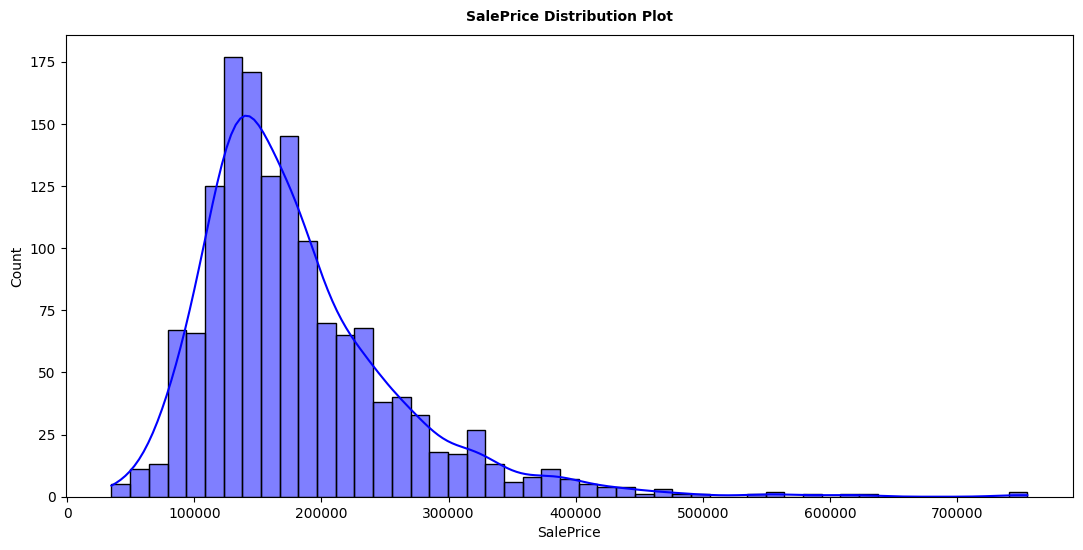

In [411]:

plt.figure(figsize=(13,6))

sns.histplot(df['SalePrice'] ,color="blue",kde=True)
plt.title("SalePrice Distribution Plot",fontweight="black",pad=10,size=10)

The target feature is having a right-skewed distribution due to presence of positive outliers.

Text(0.5, 1.0, 'Correlation with Target variable')

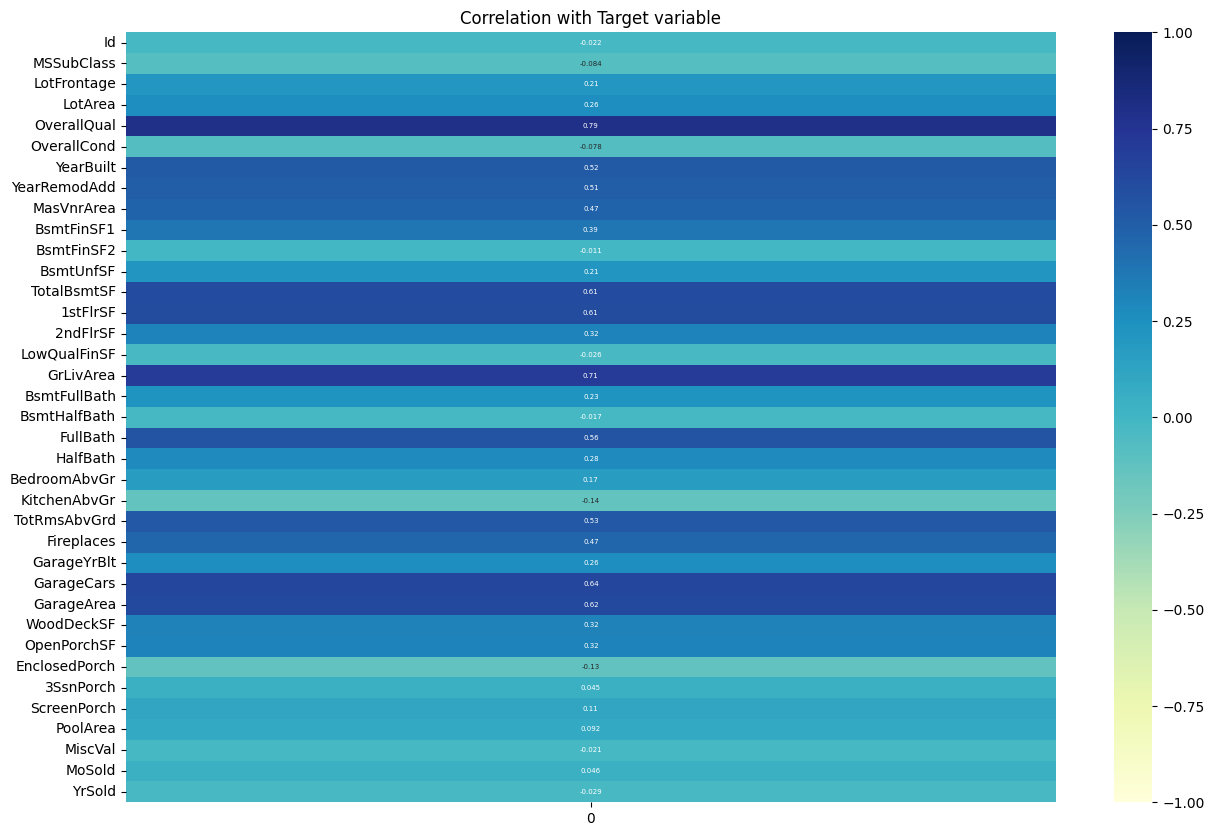

In [412]:
corr_with_target = df.drop(columns='SalePrice').corrwith(df['SalePrice'])
plt.figure(figsize=(15,10))
sns.heatmap(pd.DataFrame(corr_with_target),  cmap='YlGnBu', vmax=1.0, vmin=-1.0, annot = True,  annot_kws={"size": 5})
plt.title('Correlation with Target variable')


In [413]:
column_types = df_train.dtypes
categoricalcolumns = [column for column, dtype in column_types if dtype == "string"]
continuousCols =  [column for column, dtype in column_types if ((dtype != "string") and str(column) != "SalePrice")]



<Axes: >

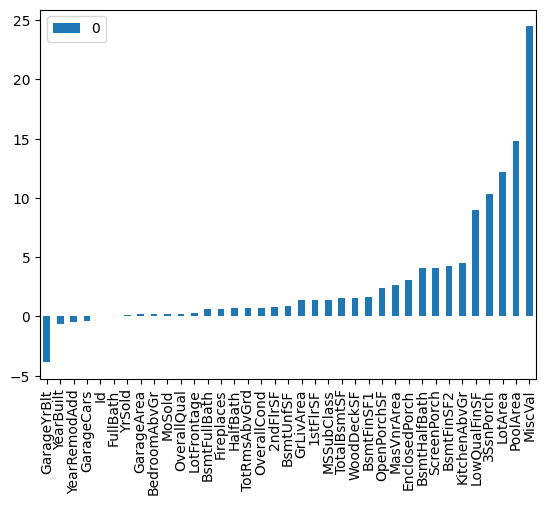

In [414]:
skewness = df[continuousCols].skew().sort_values().to_frame()
skewness.plot.bar()


Features like 3SsnPorch,LowQualFinSF,LotArea,PoolArea and MiscVal are having extremly high skewness which can create model-complexity.
We know that skewness should be near to zero for a normal distrbution to achieve that we can use different transformations.

<Axes: >

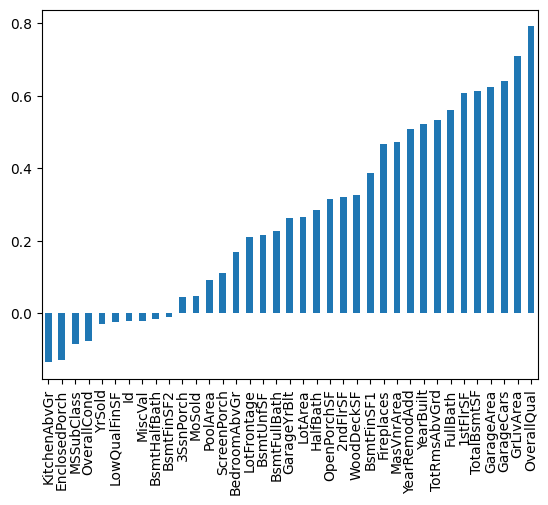

In [415]:
corr_matrix = df.drop(columns='SalePrice').corrwith(df['SalePrice']).sort_values()
corr_matrix.plot.bar()


In [416]:
#Features like LowQualFinSF,MiscVal,BsmtFinSF2,PoolArea,3SsnPorch,and ScreenPorch are having weak correlation with the target variable. So drop this features,

df_train = df_train.drop('LowQualFinSF','MiscVal', 'BsmtFinSF2', 'PoolArea', '3SsnPorch','ScreenPorch')
df_test = df_test.drop('LowQualFinSF','MiscVal', 'BsmtFinSF2', 'PoolArea', '3SsnPorch','ScreenPorch')

Creating a New Feature using all the columns storing "Bathroom Values."
FullBath: It shows total no. of Full bathrooms above grade.
HalfBath: It shows total no. of Half bathrooms above grade.
BsmtFullBath: It shows total no. of Basement full bathrooms.
BsmtHalfBath: It shows total no. of Basement half bathrooms.

In [417]:
df_train = df_train.withColumn('Total_Bathrooms', df_train["FullBath"] + (0.5 * df_train["HalfBath"]) +
                               df_train["BsmtFullBath"] + (0.5 * df_train["BsmtHalfBath"]))
df_test = df_test.withColumn('Total_Bathrooms', df_test["FullBath"] + (0.5 * df_test["HalfBath"]) +
                               df_test["BsmtFullBath"] + (0.5 * df_test["BsmtHalfBath"]))
df_train = df_train.drop("FullBath", "HalfBath", "BsmtFullBath", "BsmtHalfBath")
df_test = df_test.drop("FullBath", "HalfBath", "BsmtFullBath", "BsmtHalfBath")

In [418]:
df_train.select('Total_Bathrooms').show()

+---------------+
|Total_Bathrooms|
+---------------+
|            3.5|
|            2.5|
|            3.5|
|            2.0|
|            3.5|
|            2.5|
|            3.0|
|            3.5|
|            2.0|
|            2.0|
|            2.0|
|            4.0|
|            2.0|
|            2.0|
|            2.5|
|            1.0|
|            2.0|
|            2.0|
|            2.5|
|            1.0|
+---------------+
only showing top 20 rows



In [419]:
df_train = df_train.replace("Norm", "" , subset=['Condition2']) #Norm means normal which indicates there's no second condition

df_train = df_train.withColumn("Combined_Condition", F.concat(col("Condition1"), F.lit(" "), col("Condition2")))

df_train = df_train.drop("Condition1", "Condition2")

df_test = df_test.replace("Norm", "" , subset=['Condition2']) #Norm means normal which indicates there's no second condition

df_test = df_test.withColumn("Combined_Condition", F.concat(col("Condition1"), F.lit(" "), col("Condition2")))

df_test = df_test.drop("Condition1", "Condition2")

In [420]:
df_train = df_train.withColumn("Heating_Qu", F.concat(col("Heating"), F.lit(" - "), col("HeatingQC")))
df_train = df_train.drop("Heating", "HeatingQC")

df_test = df_test.withColumn("Heating_Qu", F.concat(col("Heating"), F.lit(" - "), col("HeatingQC")))
df_test = df_test.drop("Heating", "HeatingQC")

In [421]:
df_train.toPandas().info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Columns: 65 entries, Id to Heating_Qu
dtypes: float64(9), int32(20), object(36)
memory usage: 627.5+ KB


In [422]:
df_test.toPandas().info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Columns: 64 entries, Id to Heating_Qu
dtypes: float64(9), int32(19), object(36)
memory usage: 621.3+ KB


In [423]:
print(df_train.columns, "\n", df_test.columns)


['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtUnfSF', 'TotalBsmtSF', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition', 'SalePrice', 'Total_Bathrooms', 'Combined_Condition', 'Heating_Qu'] 
 ['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'LotShape', 'LandConto

In [424]:
from joblib import dump

In [425]:
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
#Applying string indexing to the categorical cols and removing the original cols

from pyspark.ml.feature import StringIndexer

column_types = df_train.dtypes
categoricalcolumns = [column for column, dtype in column_types if dtype == "string"]
continuousCols =  [column for column, dtype in column_types if (dtype != "string" and (str(column) != "SalePrice") and str(column) != "Id" )]

indexers = [ StringIndexer(inputCol=c, outputCol="{0}_ind".format(c))
              for c in categoricalcolumns ]

# default setting: dropLast=True
encoders = [ OneHotEncoder(inputCol=indexer.getOutputCol(),
              outputCol="{0}_enc".format(indexer.getOutputCol()))
              for indexer in indexers ]

assembler = VectorAssembler(inputCols=[encoder.getOutputCol() for encoder in encoders]
                            + continuousCols, outputCol="features")

pipeline = Pipeline(stages=indexers + encoders + [assembler])

preprocess_model = pipeline.fit(df_train)
assembledDF = preprocess_model.transform(df_train)
assembledDF_test = preprocess_model.transform(df_test)

# dump(preprocess_model, 'Inference_preprocess.joblib')


In [426]:
train = assembledDF.select("Id", "features", "SalePrice")
test =  assembledDF_test.select("Id", "features")


In [427]:
train = train.withColumn("SalePrice_final", F.log(col("SalePrice"))) # applying log transformation for saleprice

In [428]:
trainDF, testDF =  train.randomSplit([0.8,0.2], seed = 1234)


In [429]:
from pyspark.ml.regression import LinearRegression
# from pyspark.ml.linalg import SparseVector

lr = LinearRegression(featuresCol="features", labelCol="SalePrice_final", maxIter=10, regParam=0.3, elasticNetParam=0.8)

lrmodel = lr.fit(trainDF)
pred = lrmodel.transform(testDF)

type(pred)
pred.show(3)

# lrmodel.save('Inference_lrmodel')


+---+--------------------+---------+------------------+------------------+
| Id|            features|SalePrice|   SalePrice_final|        prediction|
+---+--------------------+---------+------------------+------------------+
|  2|(240,[0,4,5,8,11,...|   181500|12.109010932687042|12.017551493460124|
|  5|(240,[0,4,6,8,11,...|   250000|12.429216196844383|12.125542689203487|
| 22|(240,[1,4,5,9,11,...|   139400|11.845102777308561|12.071547091331805|
+---+--------------------+---------+------------------+------------------+
only showing top 3 rows



In [430]:
pred.select("SalePrice",  F.exp(col("prediction"))).show()

+---------+------------------+
|SalePrice|   EXP(prediction)|
+---------+------------------+
|   181500|165636.59709376981|
|   250000|184525.45292920558|
|   139400|174826.10817718334|
|   154000|156930.12092334876|
|   256300|184525.45292920558|
|   134800|156930.12092334876|
|   306000|184525.45292920558|
|   145000|156930.12092334876|
|   319900| 194762.9168992295|
|   249700|184525.45292920558|
|   110000|156930.12092334876|
|   172500|184525.45292920558|
|   196500|174826.10817718334|
|   438780|205568.35491767738|
|   140000|174826.10817718334|
|   180000|174826.10817718334|
|   129500| 148681.2895526648|
|   185000|174826.10817718334|
|   135750| 148681.2895526648|
|   168500|174826.10817718334|
+---------+------------------+
only showing top 20 rows



In [431]:
trainingSummary = lrmodel.summary
print("numIterations: %d" % trainingSummary.totalIterations)
print("objectiveHistory: %s" % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show(5)
print("RMSE: %f" % trainingSummary.rootMeanSquaredError)
print("r2: %f" % trainingSummary.r2)


numIterations: 10
objectiveHistory: [0.5000000000000568, 0.4962138319386048, 0.49128916790095356, 0.48820162591286137, 0.4854975577266928, 0.4828860023701921, 0.48086219147694925, 0.48019524734829666, 0.48007971742665007, 0.4800611555378349, 0.4800611554482691]
+--------------------+
|           residuals|
+--------------------+
| 0.17614722888918877|
| 0.24561960170395558|
|-0.22214938974036436|
|-0.09295598634639823|
|  0.5090603373658471|
+--------------------+
only showing top 5 rows

RMSE: 0.341837
r2: 0.268682


In [432]:
from pyspark.ml.regression import RandomForestRegressor

rf = RandomForestRegressor(
    labelCol="SalePrice_final",
    featuresCol="features",
    numTrees=10,  # You can adjust the number of trees in the forest
    maxBins=10     # You can adjust the maximum number of bins for features
)

rf_model = rf.fit(trainDF)

rfpredictions = rf_model.transform(testDF)

from pyspark.ml.evaluation import RegressionEvaluator

evaluator = RegressionEvaluator(
    labelCol="SalePrice_final",
    predictionCol="prediction",
    metricName="rmse"  # You can use other metrics like "mse" or "r2" as well
)

rmse = evaluator.evaluate(rfpredictions)
print("Root Mean Squared Error (RMSE) for Random Forest Regressor= {:.2f}".format(rmse))

# rfpredictions.show(5)
# rf_model.save('Inference_rf_model')
rfpredictions.select("SalePrice",  F.exp(col("prediction"))).show()

Root Mean Squared Error (RMSE) for Random Forest Regressor= 0.16
+---------+------------------+
|SalePrice|   EXP(prediction)|
+---------+------------------+
|   181500|164390.50792657945|
|   250000| 299881.2225548617|
|   139400|156101.07421471327|
|   154000|124805.98990482607|
|   256300|251359.53193968374|
|   134800|129492.17381972415|
|   306000| 294220.8143182912|
|   145000|146078.35585489043|
|   319900|288293.32784810837|
|   249700|247961.99393450312|
|   110000|130800.75249708038|
|   172500| 236437.8103056931|
|   196500|204054.85383393875|
|   438780| 370666.0952208029|
|   140000|155814.15932631507|
|   180000|229836.16167842716|
|   129500|114339.13684043376|
|   185000|190268.44420174503|
|   135750|116229.43678578718|
|   168500|190182.49089495087|
+---------+------------------+
only showing top 20 rows



In [433]:
from pyspark.ml.regression import GBTRegressor

gbt = GBTRegressor(
    labelCol="SalePrice_final",
    featuresCol="features",
    maxIter=10,       # Number of boosting iterations (trees)
    maxDepth=5        # Maximum depth of each tree (default is 5)
)

gbt_model = gbt.fit(trainDF)
gbtpredictions = gbt_model.transform(testDF)
gbtpredictions.show(5)

rmse = evaluator.evaluate(gbtpredictions)
print("Root Mean Squared Error (RMSE) for GBT Regressor = {:.2f}".format(rmse))

# gbt_model.save('Inference_gbt_model')
gbtpredictions.select("SalePrice",  F.exp(col("prediction"))).show()

+---+--------------------+---------+------------------+------------------+
| Id|            features|SalePrice|   SalePrice_final|        prediction|
+---+--------------------+---------+------------------+------------------+
|  2|(240,[0,4,5,8,11,...|   181500|12.109010932687042|12.001708963737567|
|  5|(240,[0,4,6,8,11,...|   250000|12.429216196844383|12.815937460097588|
| 22|(240,[1,4,5,9,11,...|   139400|11.845102777308561|12.113338248343815|
| 25|(240,[0,4,6,8,11,...|   154000|11.944707881395766|11.819929995857457|
| 26|(240,[0,4,5,8,11,...|   256300|12.454103912352162|12.502057443743098|
+---+--------------------+---------+------------------+------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) for GBT Regressor = 0.18
+---------+------------------+
|SalePrice|   EXP(prediction)|
+---------+------------------+
|   181500|163033.17125842767|
|   250000| 368036.5232166253|
|   139400| 182287.1095992887|
|   154000|135934.71271065652|
|   256300| 268889.94372766

In [434]:
# pred_test = lrmodel.transform(test)
# pred_test.show(5)

In [435]:
pred_test = rf_model.transform(test)
pred_test.show(5)


+----+--------------------+------------------+
|  Id|            features|        prediction|
+----+--------------------+------------------+
|1461|(240,[3,4,5,8,11,...|11.759579591054145|
|1462|(240,[0,4,6,8,11,...|11.863638099326575|
|1463|(240,[0,4,6,8,11,...|12.058935961450771|
|1464|(240,[0,4,6,8,11,...|12.109459098967395|
|1465|(240,[0,4,6,10,11...|12.178529181120538|
+----+--------------------+------------------+
only showing top 5 rows



In [436]:
# pred_test = gbt_model.transform(test)
# pred_test.show(5)

In [437]:
pred_test.select("Id", F.exp(col("prediction")).alias("SalePrice")).show()


+----+------------------+
|  Id|         SalePrice|
+----+------------------+
|1461|127973.64087795411|
|1462|142007.91853030864|
|1463|172635.19738753128|
|1464|181581.36041001842|
|1465|194566.47960973394|
|1466|  179094.548967933|
|1467|165171.82935139193|
|1468|169220.51533280016|
|1469|179947.57656061873|
|1470|122061.76651256747|
|1471| 196683.6964500533|
|1472| 111920.0737092034|
|1473|114447.76932281611|
|1474|167472.65770442085|
|1475| 157210.0467805193|
|1476| 360126.6265211131|
|1477| 243985.3621474091|
|1478| 280586.1258252736|
|1479| 271296.1730541934|
|1480| 453780.3925027549|
+----+------------------+
only showing top 20 rows

